In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler)
from scipy.stats import (pearsonr, median_abs_deviation)
from sklearn.impute import SimpleImputer

from warnings import filterwarnings
filterwarnings("ignore")
sns.set_style("whitegrid")
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=True)

In [2]:
applicants = pd.read_csv('../data/applicant.csv')
loan_details = pd.read_csv('../data/loan.csv')

print(f"applicants data rows: {applicants.shape}",
      f"\nloan data rows: {loan_details.shape}"
     )

applicants data rows: (1000, 15) 
loan data rows: (1000, 13)


In [3]:
applicants.head()

,applicant_id,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Has_been_employed_for_at_most,Telephone,Foreign_worker,Savings_account_balance,Balance_in_existing_bank_account_(lower_limit_of_bucket),Balance_in_existing_bank_account_(upper_limit_of_bucket)
0,1469590,67,male,single,1,own,4,skilled employee / official,7 years,NaN,Registered under the applicant's name,1,NaN,NaN,0
1,1203873,22,female,divorced/separated/married,1,own,2,skilled employee / official,1 year,4 years,NaN,1,Low,0,2 lac
2,1432761,49,male,single,2,own,3,unskilled - resident,4 years,7 years,NaN,1,Low,NaN,NaN
3,1207582,45,male,single,2,for free,4,skilled employee / official,4 years,7 years,NaN,1,Low,NaN,0
4,1674436,53,male,single,2,for free,4,skilled employee / official,1 year,4 years,NaN,1,Low,NaN,0


In [4]:
loan_details.head()

,loan_application_id,applicant_id,Months_loan_taken_for,Purpose,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Has_coapplicant,Has_guarantor,Other_EMI_plans,Number_of_existing_loans_at_this_bank,Loan_history,high_risk_applicant
0,d68d975e-edad-11ea-8761-1d6f9c1ff461,1469590,6,electronic equipment,1169000,4,real estate,0,0,NaN,2,critical/pending loans at other banks,0
1,d68d989e-edad-11ea-b1d5-2bcf65006448,1203873,48,electronic equipment,5951000,2,real estate,0,0,NaN,1,existing loans paid back duly till now,1
2,d68d995c-edad-11ea-814a-1b6716782575,1432761,12,education,2096000,2,real estate,0,0,NaN,1,critical/pending loans at other banks,0
3,d68d99fc-edad-11ea-8841-17e8848060ae,1207582,42,FF&E,7882000,2,building society savings agreement/life insurance,0,1,NaN,1,existing loans paid back duly till now,0
4,d68d9a92-edad-11ea-9f3d-1f8682db006a,1674436,24,new vehicle,4870000,3,NaN,0,0,NaN,2,delay in paying off loans in the past,1


## Data Cleaning & Data Preparation:

- Check If there are applicants 80 or aboeve 80 years of age, since at the age or above 80 years old people wont be able to take loans.

In [5]:
applicants.loc[applicants['Primary_applicant_age_in_years'] >= 80].shape

(0, 15)

In [6]:
missing_values = applicants.isna().sum()
missing_values[missing_values > 0] / len(applicants)

Has_been_employed_for_at_least                              0.062
Has_been_employed_for_at_most                               0.253
Telephone                                                   0.596
Savings_account_balance                                     0.183
Balance_in_existing_bank_account_(lower_limit_of_bucket)    0.668
Balance_in_existing_bank_account_(upper_limit_of_bucket)    0.457
dtype: float64

In [7]:
missing_loan_details = loan_details.isna().sum()
missing_loan_details[missing_loan_details > 0] / len(loan_details)

Purpose            0.012
Property           0.154
Other_EMI_plans    0.814
dtype: float64

## Dropping columns with maximum missing values:

In [8]:
applicants.drop(columns = ["Balance_in_existing_bank_account_(lower_limit_of_bucket)",
                           "Balance_in_existing_bank_account_(upper_limit_of_bucket)",
                           "Telephone"], 
                inplace=True
               )
loan_details.drop(columns=["loan_application_id", "Other_EMI_plans"], inplace=True)

In [9]:
applicants.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   applicant_id                    1000 non-null   int64 
 1   Primary_applicant_age_in_years  1000 non-null   int64 
 2   Gender                          1000 non-null   object
 3   Marital_status                  1000 non-null   object
 4   Number_of_dependents            1000 non-null   int64 
 5   Housing                         1000 non-null   object
 6   Years_at_current_residence      1000 non-null   int64 
 7   Employment_status               1000 non-null   object
 8   Has_been_employed_for_at_least  938 non-null    object
 9   Has_been_employed_for_at_most   747 non-null    object
 10  Foreign_worker                  1000 non-null   int64 
 11  Savings_account_balance         817 non-null    object
dtypes: int64(5), object(7)
memory usage: 93.9+ KB


In [10]:
# -- Renaming the columns for the readability, keeping the meaning unchanged. 
applicants.rename(columns={"Primary_applicant_age_in_years": "age", 
                           "Gender": "gender", 
                           "Marital_status": "marital_status",
                           "Number_of_dependents": "no_of_dependents",
                           "Housing": "housing",
                           "Years_at_current_residence": "residency(years)",
                           "Employment_status": "employment_status",
                           "Has_been_employed_for_at_least": "at_least_employment(years)",
                           "Has_been_employed_for_at_most": "at_most_employment(years)",
                           "Telephone": "telephone",
                           "Foreign_worker": "foreign_worker",
                           "Savings_account_balance": "ac_balance(savings)",
                          }, 
                  inplace=True
                 )

In [11]:
loan_details.rename(columns={"Months_loan_taken_for": "loan_taken_over(months)", 
                             "Purpose": "purpose",
                             "Principal_loan_amount": "loan_amt",
                             "EMI_rate_in_percentage_of_disposable_income": "emi_rate(percent)",
                             "Property": "property",
                             "Has_coapplicant": "has_coapplicant",
                             "Has_guarantor": "has_guarantor",
                             "Number_of_existing_loans_at_this_bank": "existing_loans(total)",
                             "Loan_history": "loan_history",
                             "high_risk_applicant": "risk"
                            },
                    inplace=True
                   )

In [12]:
data = applicants.merge(loan_details)
data.head()

,applicant_id,age,gender,marital_status,no_of_dependents,housing,residency(years),employment_status,at_least_employment(years),at_most_employment(years),...,loan_taken_over(months),purpose,loan_amt,emi_rate(percent),property,has_coapplicant,has_guarantor,existing_loans(total),loan_history,risk
0,1469590,67,male,single,1,own,4,skilled employee / official,7 years,NaN,...,6,electronic equipment,1169000,4,real estate,0,0,2,critical/pending loans at other banks,0
1,1203873,22,female,divorced/separated/married,1,own,2,skilled employee / official,1 year,4 years,...,48,electronic equipment,5951000,2,real estate,0,0,1,existing loans paid back duly till now,1
2,1432761,49,male,single,2,own,3,unskilled - resident,4 years,7 years,...,12,education,2096000,2,real estate,0,0,1,critical/pending loans at other banks,0
3,1207582,45,male,single,2,for free,4,skilled employee / official,4 years,7 years,...,42,FF&E,7882000,2,building society savings agreement/life insurance,0,1,1,existing loans paid back duly till now,0
4,1674436,53,male,single,2,for free,4,skilled employee / official,1 year,4 years,...,24,new vehicle,4870000,3,NaN,0,0,2,delay in paying off loans in the past,1


In [13]:
missing_data = data.isna().sum()
missing_data[missing_data > 0] / len(data)

at_least_employment(years)    0.062
at_most_employment(years)     0.253
ac_balance(savings)           0.183
purpose                       0.012
property                      0.154
dtype: float64

In [14]:
def column_info(column_name: str) -> str:
    """ returns value counts of a column variables 
        and total number of missing values 
    """
    if column_name not in data.columns:
        print(f"Given {column_name} is not present in the dataset")
        return
    if data[column_name].dtype in ["O", "int64", "float64"]:
        print(f"----- {column_name} -----",
              f"\n{data[column_name].value_counts()}",
              f"\n------------------------------",
              f"\nTotal missing values: {data[column_name].isna().sum()}\n",
             )
    else:
        return f"Check given {column_name}'s data type."

In [15]:
columns = ['property', 'purpose', 'housing', 'marital_status', 'gender', 'employment_status', 'loan_history', 'risk']
print([column_info(col) for col in columns])

----- property ----- 
car or other                                         332
real estate                                          282
building society savings agreement/life insurance    232
Name: property, dtype: int64 
------------------------------ 
Total missing values: 154

----- purpose ----- 
electronic equipment    280
new vehicle             234
FF&E                    181
used vehicle            103
business                 97
education                50
repair costs             22
domestic appliances      12
career development        9
Name: purpose, dtype: int64 
------------------------------ 
Total missing values: 12

----- housing ----- 
own         713
rent        179
for free    108
Name: housing, dtype: int64 
------------------------------ 
Total missing values: 0

----- marital_status ----- 
single                        548
divorced/separated/married    310
married/widowed                92
divorced/separated             50
Name: marital_status, dtype: int64 
---

## Impute missing values in Categorical data:

In [16]:
data["at_least_employment(years)"] = data["at_least_employment(years)"].str.replace("years", "")
data["at_least_employment(years)"] = data["at_least_employment(years)"].str.replace("year", "")
data["at_least_employment(years)"].fillna(0, inplace=True)
data["at_least_employment(years)"] = data["at_least_employment(years)"].astype(str).astype(np.float64)
data["at_least_employment(years)"].replace(0, data["at_least_employment(years)"].mean(), inplace=True)

data["at_most_employment(years)"] = data["at_most_employment(years)"].str.replace("years", "")
data["at_most_employment(years)"] = data["at_most_employment(years)"].str.replace("year", "")
data["at_most_employment(years)"].fillna(0, inplace=True)
data["at_most_employment(years)"] = data["at_most_employment(years)"].astype(str).astype(np.float64)
data["at_most_employment(years)"].replace(0, data["at_most_employment(years)"].mean(), inplace=True)

In [17]:
# -- savings account balance --
# -- 0 for High and Very high since there wasn't much difference in numbers:
data["ac_balance(savings)"] = data["ac_balance(savings)"].map({"Low": 1, "Medium": 2, "High":0, "Very High":0})
data["ac_balance(savings)"].fillna(data["ac_balance(savings)"].mean(), inplace=True)

In [18]:
imputer = SimpleImputer(strategy="most_frequent", missing_values=np.nan).fit(data[["property", "purpose"]])
data[["property", "purpose"]] = imputer.transform(data[["property", "purpose"]])

data.isna().sum().sort_values(ascending=False)

applicant_id                  0
age                           0
loan_history                  0
existing_loans(total)         0
has_guarantor                 0
has_coapplicant               0
property                      0
emi_rate(percent)             0
loan_amt                      0
purpose                       0
loan_taken_over(months)       0
ac_balance(savings)           0
foreign_worker                0
at_most_employment(years)     0
at_least_employment(years)    0
employment_status             0
residency(years)              0
housing                       0
no_of_dependents              0
marital_status                0
gender                        0
risk                          0
dtype: int64

In [19]:
data['property'] = data["property"].map({"car or other": "car/other", "real estate": "real estate", 
                                         "building society savings agreement/life insurance": "insurance"
                                        }
                                       )

In [20]:
# -- marital status --
# >> code here: change categories !

## Low risk vs High risks: (target variable distribution)

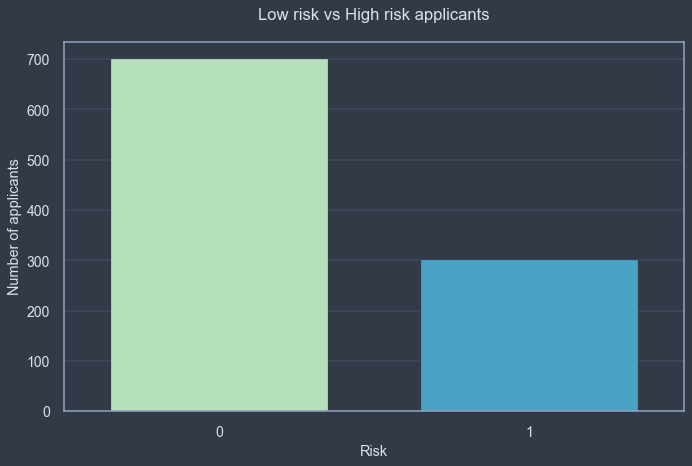

Percentage of high risk cases is: 43%
High risk applicants: 300 
Low risk applicants: 700


In [21]:
plt.figure(figsize=(10, 6), dpi=80)
sns.countplot(data=data, x=data.risk, palette="GnBu", width=.7, saturation=.9);
plt.title("Low risk vs High risk applicants", size=15, pad=20)
plt.xlabel("Risk", size=13)
plt.ylabel("Number of applicants", size=13)
plt.show()

low_risk_ppl = data[data['risk']==0]
high_risk_ppl = data[data['risk']==1]

print('Percentage of high risk cases is: {:.0%}'.format(len(high_risk_ppl)/len(low_risk_ppl)))
print(f"High risk applicants: {len(data[data['risk'] == 1])}", 
      f"\nLow risk applicants: {len(data[data['risk']== 0])}"
     )

It is understood that most of the customers are low credit risk, maybe they are earning well, pays their due time to time. To be more precise, the number of customers who are high risks is 183 in total and the number of low risk customers is 517 which means __43%__ of the customers are high risks.

## Male vs Female Credit Risk:

In [22]:
# -- Male and female with low credit risk -- 
filter_male_low = (data['gender']=='male') & (data['risk'] == 0)
filter_female_low = (data['gender'] == 'female') & (data['risk'] == 0)

# -- Male and female with high credit risk -- 
filter_male = (data['gender']=='male') & (data['risk'] == 1)
filter_female = (data['gender'] == 'female') & (data['risk'] == 1)
# data.loc[filter_male]

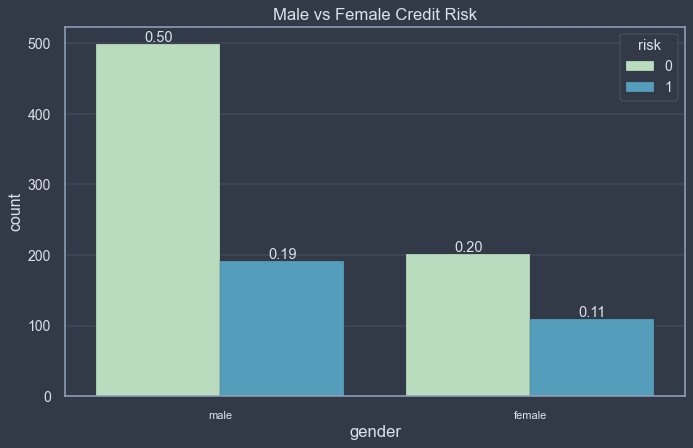

--------------------------------------------------------------------------------
Men low credit risk: 499 applicants. 
Female low credit risk: 201 applicants. 

Men high credit risk: 191 applicants. 
Female high credit risk: 109 applicants.


In [23]:
# -- Visualization --
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
ax = sns.countplot(x="gender", hue = "risk", data=data, palette="GnBu")
ax.set_xticklabels(ax.get_xticklabels(), size=10)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3, 
            '{:1.2f}'.format(height/data.shape[0]), ha="center"
           )
plt.xlabel("gender", size=15)
plt.title("Male vs Female Credit Risk", size=15)
plt.show()

print('-'*80)

print(f"Men low credit risk: {data.loc[filter_male_low].shape[0]} applicants.",
      f"\nFemale low credit risk: {data.loc[filter_female_low].shape[0]} applicants.",
      f"\n\nMen high credit risk: {data.loc[filter_male].shape[0]} applicants.",
      f"\nFemale high credit risk: {data.loc[filter_female].shape[0]} applicants."
     )

### Notes:

0 = __Low credit risk__ i.e high chance of paying back the loan amount.  
 - There are total __499 men__ and __201 females__ with low credit risk.
 - Graph clearly shows that men are highly likely to pay their loans and has a great difference between men with high credit risk and men with low credit risk.

<br>

1 = __High credit risk__ i.e low chance of paying back the loan amount.
 - There are total __191 males__ and __109 females__ with high credit risk. 

<br>
 The ratio of male vs female applicants for the loan is unbalanced or not even.<br>
 There are 690 male and 310 female applicants.

## Employement Status vs Credit Risk:

In [24]:
column_info('employment_status')

----- employment_status ----- 
skilled employee / official                                         630
unskilled - resident                                                200
management / self-employed / highly qualified employee / officer    148
unemployed / unskilled - non-resident                                22
Name: employment_status, dtype: int64 
------------------------------ 
Total missing values: 0



- __"skilled employee / official"__ and __"management / self-employed / highly qualified employee / officer"__ two categories seems to be same.
- Because people in first category has employement (job): source of earning.
- Third category shows that there are people who may have their own businesses or are self employed, and has source of earnings as well.
- Therefore I'm combining these two categories here.
<br>

- __"unskilled - resident"__ and __"unemployed / unskilled - non-resident"__ categories also seems same, unskilled-resident seems like these are the unskilled/unemployed people who are resident in that area but has no source of income, same goes with the second category that I'm considering here, but these are non resident.

In [25]:
# -- Employment status --
data["employment_status"] = data['employment_status'].str.replace("unemployed / unskilled - non-resident", 
                                                                              "unemployed")
data["employment_status"] = data['employment_status'].str.replace("skilled employee / official", "officer")
data["employment_status"] = data["employment_status"].str.replace("management / self-employed / highly qualified employee / officer",
                                                                              "officer")
data["employment_status"] = data["employment_status"].str.replace("unskilled - resident", "unemployed")
data.employment_status.value_counts()

officer       778
unemployed    222
Name: employment_status, dtype: int64

In [26]:
high_cred_officer = (data["employment_status"] == "officer") & (data["risk"] == 1)
high_cred_unemp = (data["employment_status"] == "unemployed") & (data['risk'] == 1)

low_cred_officer = (data["employment_status"] == "officer") & (data["risk"] == 0)
low_cred_unemp = (data["employment_status"] == "unemployed") & (data['risk'] == 0)

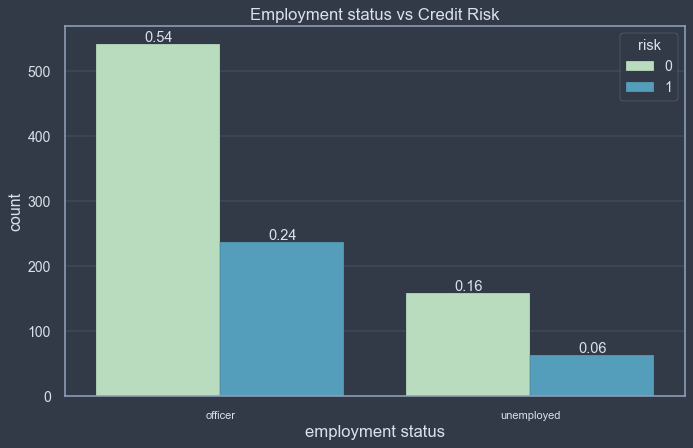

--------------------------------------------------------------------------------
high credit risk: officials: 237 
high credit risk: unemployed: 63 

low credit risk: officials: 541 
low credit risk: unemployed: 159


In [27]:
# -- Visualization --
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
ax = sns.countplot(x="employment_status", hue = "risk", data=data, palette="GnBu")
ax.set_xticklabels(ax.get_xticklabels(), size=10)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3, 
            '{:1.2f}'.format(height/data.shape[0]), ha="center"
           )
plt.xlabel("employment status", size=15)
plt.title("Employment status vs Credit Risk", size=15)
plt.show()
print("-"*80)
print(f"high credit risk: officials: {len(data.loc[high_cred_officer])}",
      f"\nhigh credit risk: unemployed: {len(data.loc[high_cred_unemp])}",
      f"\n\nlow credit risk: officials: {len(data.loc[low_cred_officer])}",
      f"\nlow credit risk: unemployed: {len(data.loc[low_cred_unemp])}",
     )

- There are officals/who are employed have __lowest credit risk__ and there are some with __high credit risk__. There are total 541 employees with low credit risk and 237 with high credit risk.
<br>

- In Unemployed category there are 159 applicants with low credit risk and 63 are wiht high credit risk.

## Granted Credits for various purpose: Age wise.

In [28]:
print(f"Values describe: ",
      f"\n{pd.crosstab(data.purpose, data.risk)}"
     )

Values describe:  
risk                    0   1
purpose                      
FF&E                  123  58
business               63  34
career development      8   1
domestic appliances     8   4
education              28  22
electronic equipment  225  67
new vehicle           145  89
repair costs           14   8
used vehicle           86  17


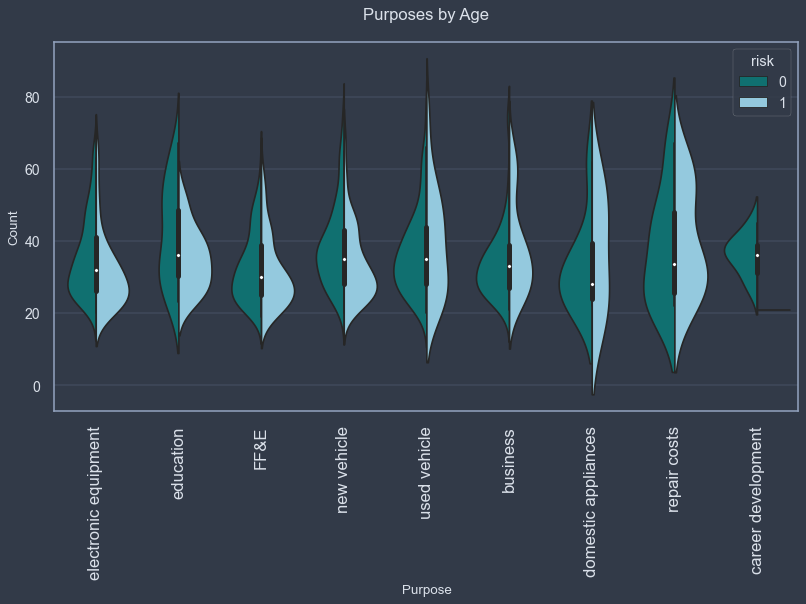

In [29]:
plt.figure(figsize=(12, 6), dpi=80)
g1 = sns.violinplot(x="purpose", y="age", data=data, palette=['teal', 'skyblue'], hue="risk", split=True)
g1.set_xticklabels(g1.get_xticklabels(), rotation=90, size=15)
g1.set_xlabel("Purpose", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Purposes by Age", fontsize=15, pad=20)
plt.show()

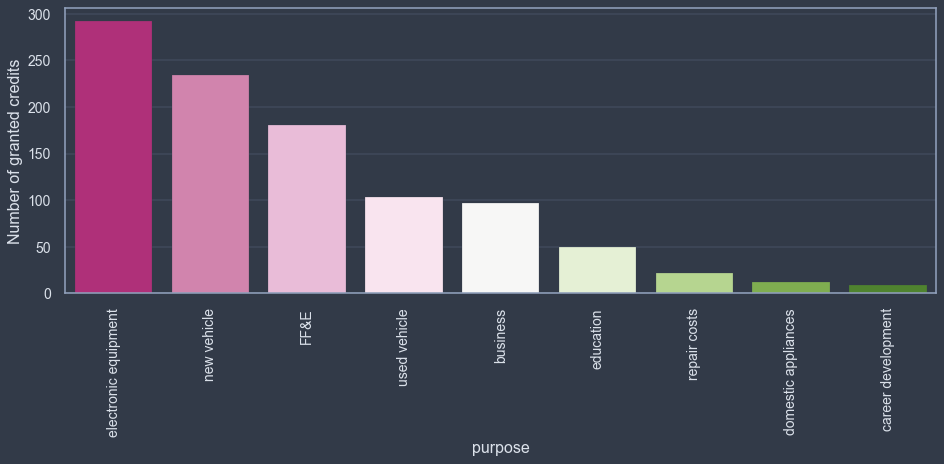

In [30]:
n_credits = data.groupby("purpose")["age"].count().rename("count").reset_index()
n_credits.sort_values(by=["count"], ascending=False, inplace=True)

plt.figure(figsize=(12, 6), dpi=80)
bar = sns.barplot(x="purpose", y="count", data=n_credits, palette="PiYG")
bar.set_xticklabels(bar.get_xticklabels(), rotation=90)
plt.ylabel("Number of granted credits")
plt.tight_layout()

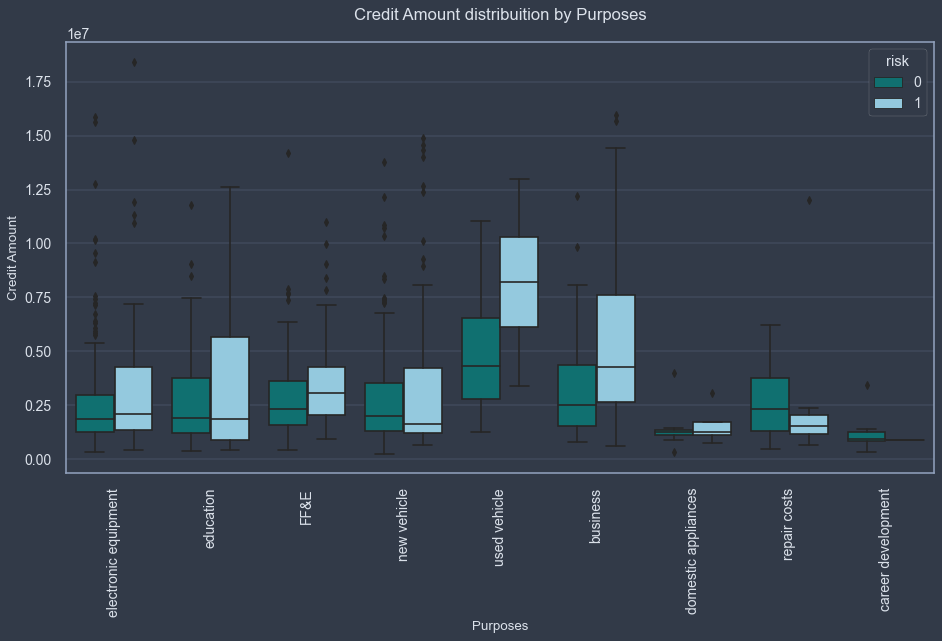

In [31]:
plt.figure(figsize=(14, 7), dpi=80)
g2 = sns.boxplot(x="purpose", y="loan_amt", data=data, palette=['teal', 'skyblue'], hue = "risk")
g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
g2.set_xlabel("Purposes", fontsize=12)
g2.set_ylabel("Credit Amount", fontsize=12)
g2.set_title("Credit Amount distribuition by Purposes", fontsize=15, pad=20)
plt.show()

- The barplot above shows how many credits were granted for various purposes. Most of credits were granted for __electronic equipments__ and __new vehicle.__

- Now I will generate boxplots for detailed analysis of categorical variables.

## Visualizing relationship:

In [32]:
def scatters(data, h: str = None, pal: str = None) -> plt.plot:
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9,11))
    sns.scatterplot(x="loan_amt", y="loan_taken_over(months)", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="age",y="loan_amt", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="age",y="loan_taken_over(months)", hue=h, palette=pal, data=data, ax=ax3)
    plt.subplots_adjust(hspace = 0.4,top = 0.9)
    plt.show()

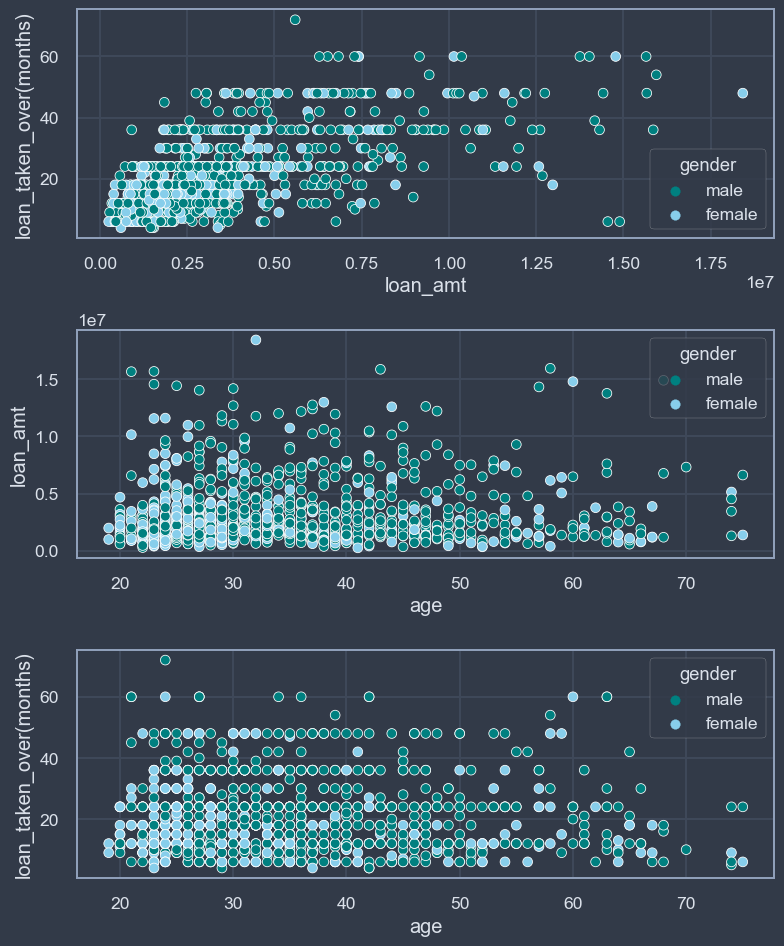

In [33]:
scatters(data, h='gender', pal=['teal', 'skyblue'])

### Notes:

- The general impression is that women tend to be younger than men, however, the top plot shows that there is no clear difference between men and women in terms of amount and duration of the credit. From visual inspection, it seems that there is some __positive correlation__ between __duration__ and __loan amount__, what makes sense.

## Let’s check the __linear correlation__ between __loan amount__ and __duration__.

Pearson correlation: 0.625, P-value: 1.8628512880508719e-109
--------------------------------------------------------------------------------


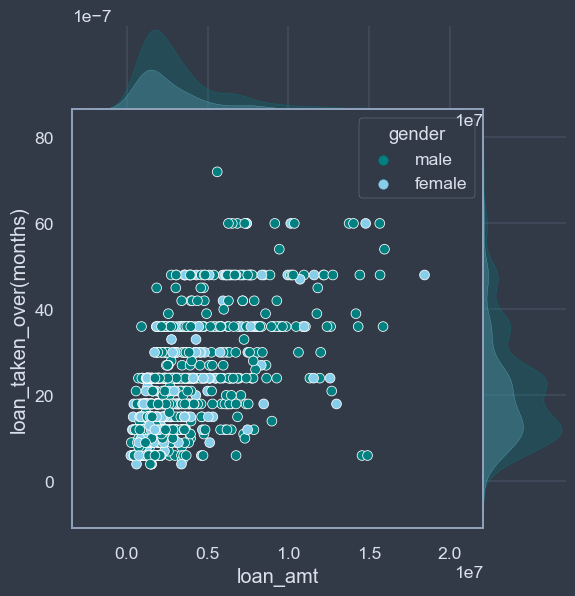

In [34]:
x = data["loan_amt"].values
y = data["loan_taken_over(months)"].values
corr_coef, p_val = pearsonr(x, y)
print(f"Pearson correlation: {round(corr_coef, 3)}, P-value: {p_val}")

print("-"*80)

sns.jointplot(data=data, x="loan_amt",y="loan_taken_over(months)",
              hue="gender", space=0, palette=['teal','skyblue'], kind="scatter"
             )
plt.grid(False)
plt.show()

### Notes:

- The plot above shows a linear correlation with Pearson value of __0.63__ and very small __p-value__. That make’s sense because usually, people take bigger credits for longer periods. Below I will analyse linear regression plots with various categorisations.

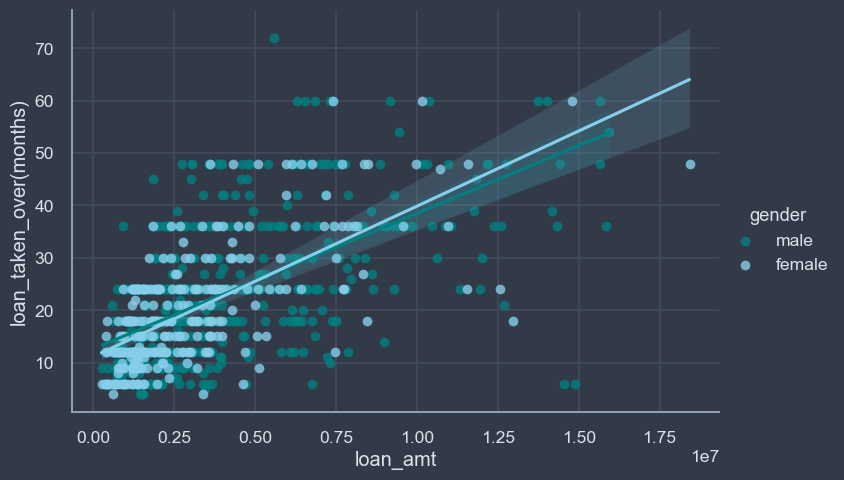

In [35]:
sns.lmplot(data=data, x="loan_amt", y="loan_taken_over(months)", hue="gender", palette=['teal', 'skyblue'], 
           aspect=1.5, height=5
          );

- As the loan amount is increases the time to pay due increases as well.

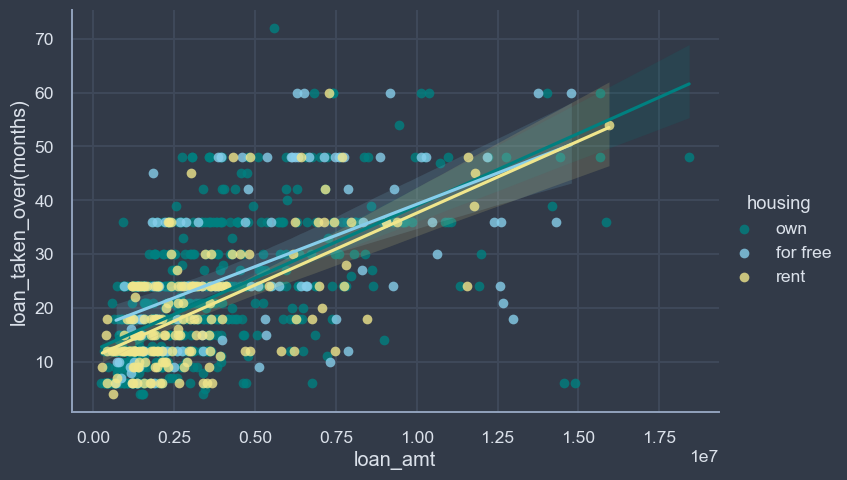

In [36]:
sns.lmplot(data=data, x="loan_amt", y="loan_taken_over(months)", hue="housing", palette=['teal', 'skyblue', 'khaki'], 
           aspect=1.5, height=5
          );

- The plot above shows similarly that there is no diference betwen housing categories.

In [37]:
def boxes(x: str, y: str, h: str = None, pal: str = None) -> plt.plot:
    """ The box plot shows the distribution of a variable in terms of median and quartiles """
    fig, ax = plt.subplots(figsize=(10,6), dpi=80)
    box = sns.boxplot(x=x,y=y, hue=h, data=data, palette=pal, saturation=.9)
    box.set_xticklabels(box.get_xticklabels(), rotation=90, size=15)
    fig.subplots_adjust(bottom=0.2)
    plt.xlabel(x, size=15)
    plt.ylabel(y, size=15)
    plt.tight_layout()

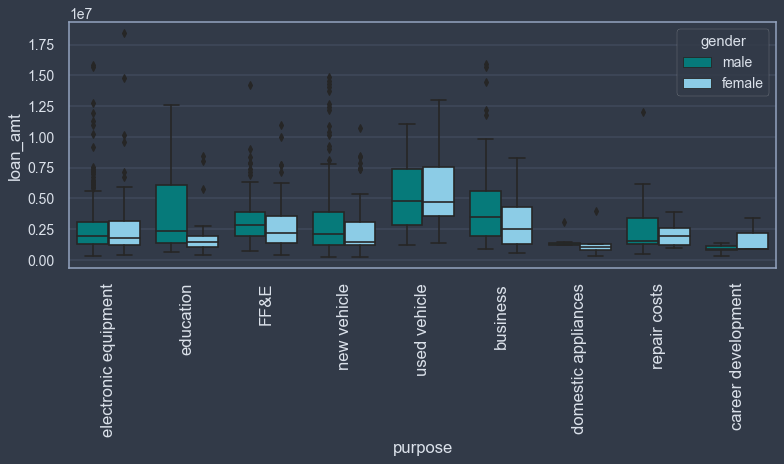

In [38]:
boxes("purpose", "loan_amt", "gender", ["teal", "skyblue"])

The plot above shows that the biggest amounts are taken for vacations/others, the smallest for domestic appliances. Most of them have outliers on the upper side of the boxes (higher amounts). In most of the cases there is no difference between men and women, despite category vacation/others. But one must remember that there was very little number of credits granted in this category.

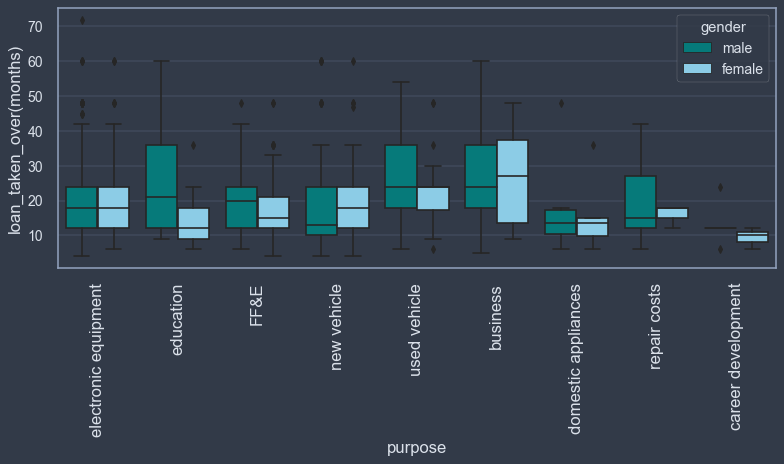

In [39]:
boxes("purpose", "loan_taken_over(months)", "gender", ["teal", "skyblue"])

The boxplot above indicates that generally there is no difference in credit duration between men and women. We can’t see also clear trend between categories with observations that the shortest duration is for domestic appliances. It makes sense as it is in agreement with insights from the previous graph (credit amount) – in this category, there are the lowest amounts of credits.

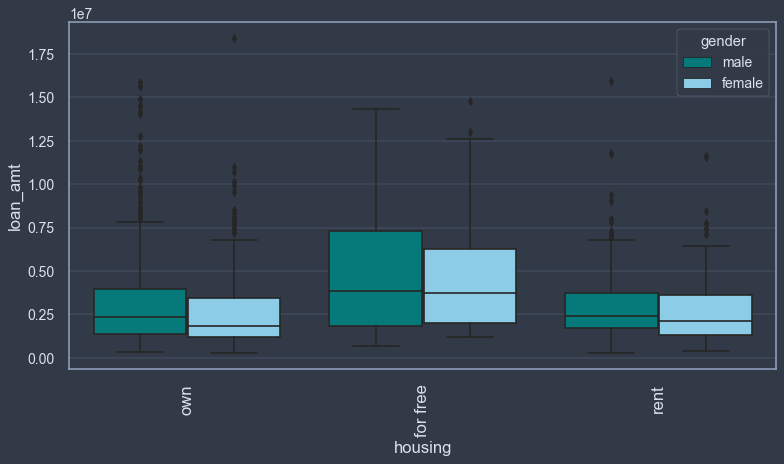

In [40]:
boxes("housing", "loan_amt", "gender", ["teal", "skyblue"])

In terms of housing category, there is no big difference despite people having “free” housing tend to take slightly bigger credit amounts.

## Outliers:

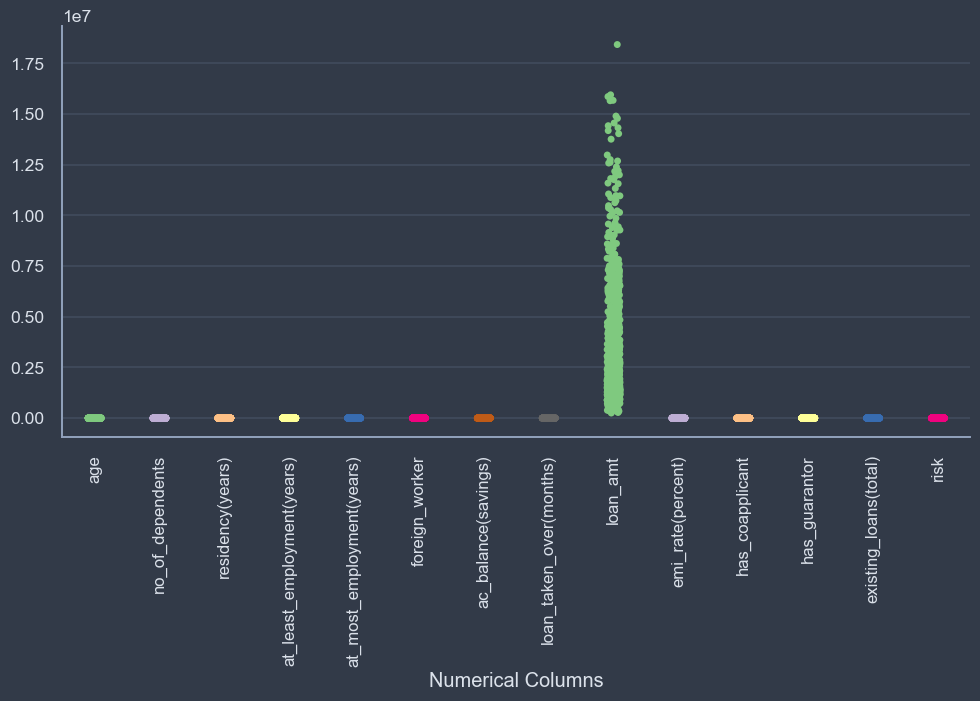

In [41]:
num_data = data._get_numeric_data()
cat = sns.catplot(data=num_data.iloc[:, 1:], palette="Accent", aspect=2)
cat.set_xticklabels(num_data.columns[1:], rotation=90, size=12)
cat.set_xlabels('Numerical Columns')
plt.show()

- Loan Amount variable has extreme outlieres: As people are taking loans from smallest to biggest amount as possible.

## I will do some explorations through the Employment Status

- Distribuition
- Crossed by Credit amount
- Crossed by Age

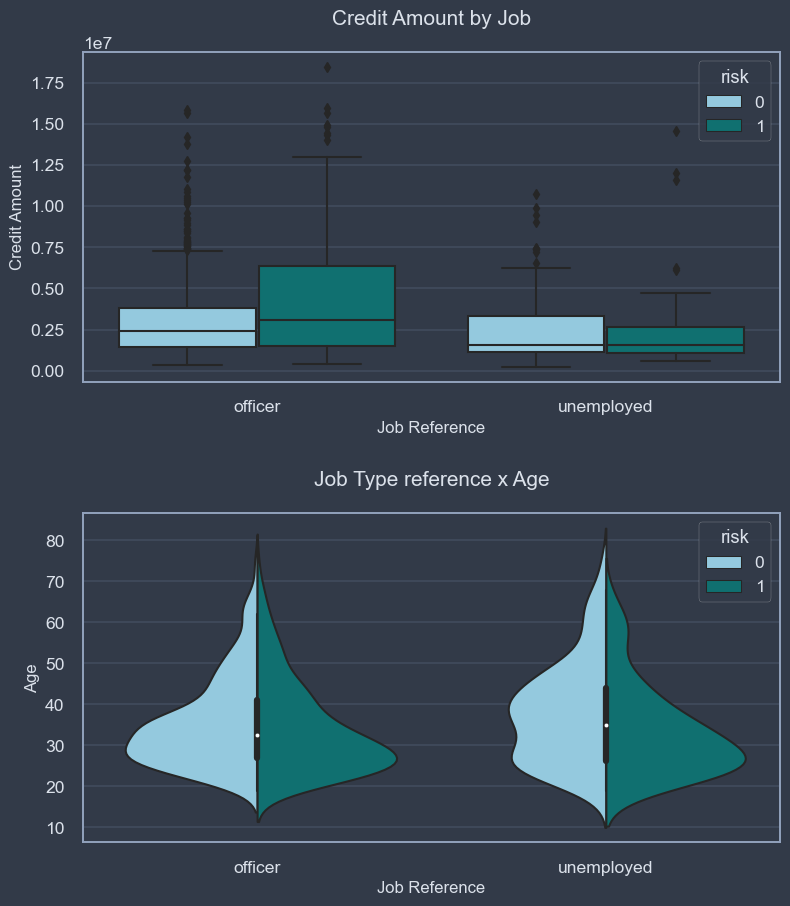

In [42]:
fig, ax = plt.subplots(figsize=(9, 10), dpi=100, nrows=2)

g1 = sns.boxplot(x="employment_status", y="loan_amt", data=data, 
                 palette=['skyblue', 'teal'], ax=ax[0], hue="risk")
g1.set_title("Credit Amount by Job", fontsize=15, pad=20)
g1.set_xlabel("Job Reference", fontsize=12)
g1.set_ylabel("Credit Amount", fontsize=12)

g2 = sns.violinplot(x="employment_status", y="age", data=data, ax=ax[1], 
                    hue="risk", split=True, palette=['skyblue','teal'])
g2.set_title("Job Type reference x Age", fontsize=15, pad=20)
g2.set_xlabel("Job Reference", fontsize=12)
g2.set_ylabel("Age", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()

## Distribuition of Loan Amount

In [43]:
low_risk_df = data[data['risk']==0]
high_risk_df = data[data['risk']==1]

x1 = low_risk_df['loan_amt']
x2 = high_risk_df['loan_amt']

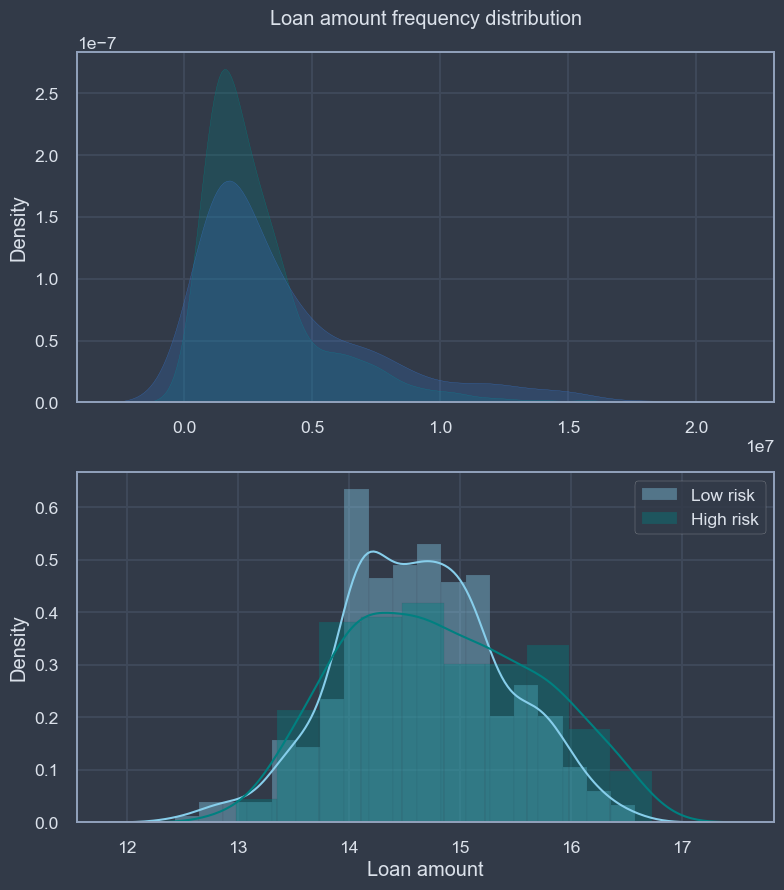

In [44]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9, 10))
fig = sns.kdeplot(x1, shade=True, color="teal",ax=ax1)
fig = sns.kdeplot(x2, shade=True, color="b", ax=ax1)
fig.set_title("Loan amount frequency distribution", pad=20)
fig = sns.distplot(np.log(x1), color="skyblue", label="Low risk", ax=ax2)
fig = sns.distplot(np.log(x2), color="teal", label="High risk", ax=ax2)
ax1.set_xlabel("")
ax2.set_xlabel("Loan amount")
plt.legend()
plt.show()

## Duration of the loans distribuition and density:

In [45]:
print("Description of Distribuition Saving accounts by Risk:",
      f"\n{pd.crosstab(data['ac_balance(savings)'], data.risk)}"
     )

Description of Distribuition Saving accounts by Risk: 
risk                   0    1
ac_balance(savings)          
0.000000              52   11
1.000000             386  217
1.052016             193   38
2.000000              69   34


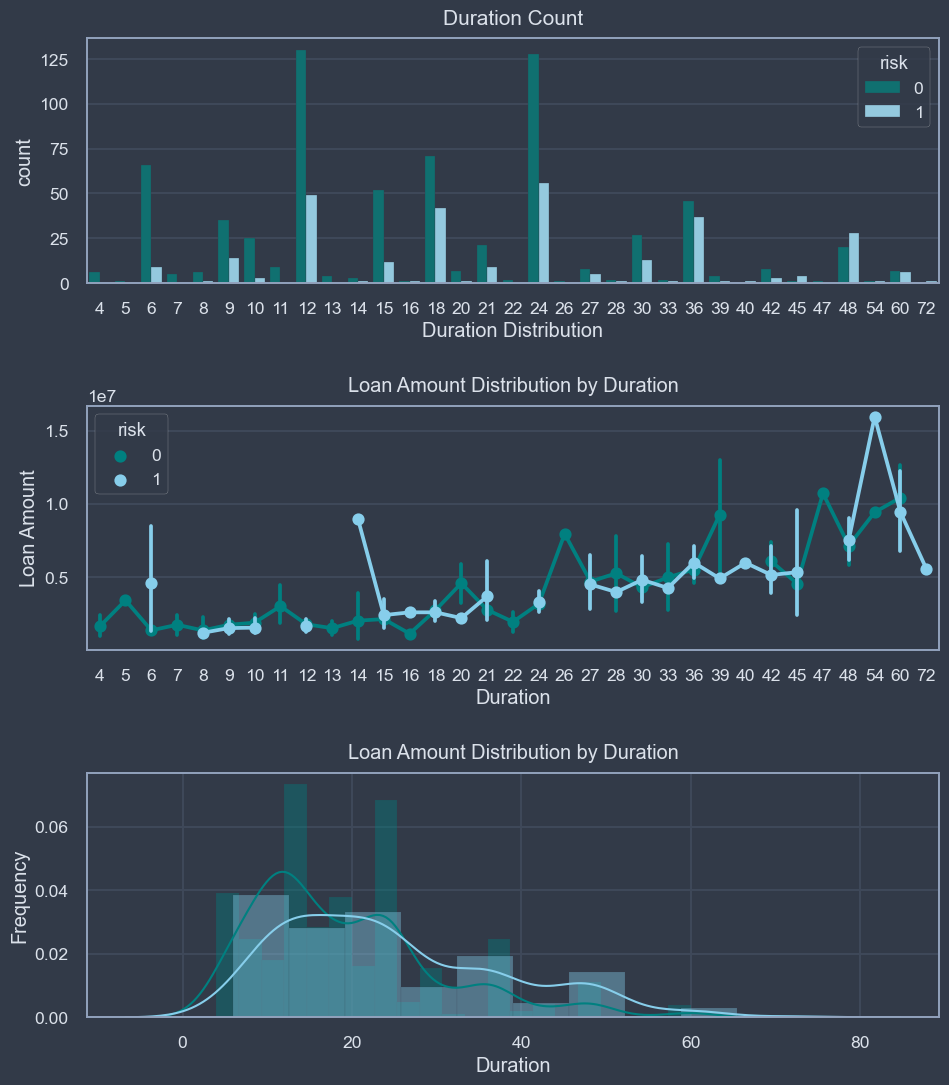

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(11, 11))
sns.countplot(x="loan_taken_over(months)", hue="risk", palette=['teal', 'skyblue'], data=data, ax=ax1)
ax1.set_xlabel("Duration Distribution")
ax1.set_title("Duration Count", size=15, pad=10)

sns.pointplot(x="loan_taken_over(months)", y="loan_amt", hue='risk', palette=['teal', 'skyblue'], data=data, ax=ax2)
ax2.set_xlabel("Duration")
ax2.set_ylabel("Loan Amount")
ax2.set_title("Loan Amount Distribution by Duration", pad=10)

sns.distplot(low_risk_df['loan_taken_over(months)'], color='teal', ax=ax3)
sns.distplot(high_risk_df['loan_taken_over(months)'], color='skyblue', ax=ax3)
ax3.set_xlabel("Duration")
ax3.set_ylabel("Frequency")
ax3.set_title("Loan Amount Distribution by Duration", pad=10)
plt.subplots_adjust(hspace = 0.5, top = 1.)
plt.show()

## Crosstabs and Exploring more features:

In [47]:
print(pd.crosstab(data.employment_status, data.gender))

gender             female  male
employment_status              
officer               234   544
unemployed             76   146


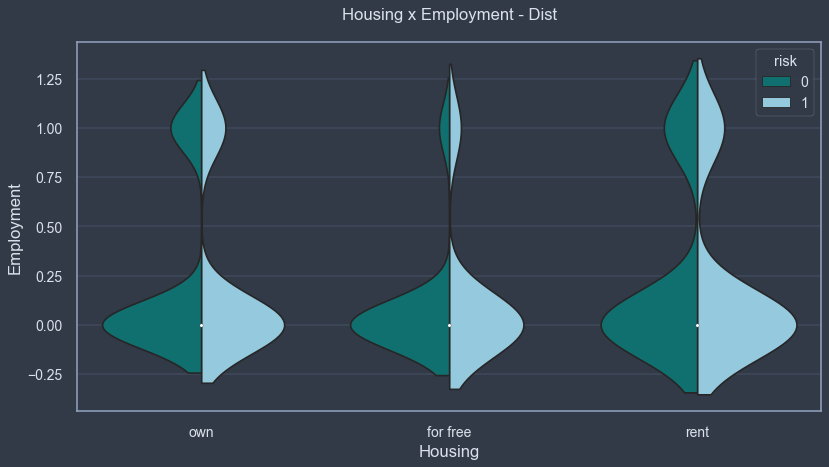

In [48]:
plt.figure(figsize=(12, 6), dpi=80)
g = sns.violinplot(x=data["housing"], y=data["employment_status"].map({'officer': 0, 'unemployed':1}), 
                   data=data, hue="risk", palette=['teal', 'skyblue'], split=True)
g.set_xlabel("Housing", fontsize=15)
g.set_ylabel("Employment", fontsize=15)
g.set_title("Housing x Employment - Dist", fontsize=15, pad=20)
plt.show()

In [49]:
dumb_data = ["purpose", 'gender']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(data[dumb_data[0]], data[dumb_data[1]]).style.background_gradient(cmap = cm)

gender,female,male
purpose,,
FF&E,74,107
business,19,78
career development,3,6
domestic appliances,6,6
education,21,29
electronic equipment,88,204
new vehicle,70,164
repair costs,5,17
used vehicle,24,79


## Total of values in each categorical feature:

In [50]:
cat_cols = data.select_dtypes(include=["object", "boolean"]).columns.to_list()
print([column_info(col) for col in cat_cols])

----- gender ----- 
male      690
female    310
Name: gender, dtype: int64 
------------------------------ 
Total missing values: 0

----- marital_status ----- 
single                        548
divorced/separated/married    310
married/widowed                92
divorced/separated             50
Name: marital_status, dtype: int64 
------------------------------ 
Total missing values: 0

----- housing ----- 
own         713
rent        179
for free    108
Name: housing, dtype: int64 
------------------------------ 
Total missing values: 0

----- employment_status ----- 
officer       778
unemployed    222
Name: employment_status, dtype: int64 
------------------------------ 
Total missing values: 0

----- purpose ----- 
electronic equipment    292
new vehicle             234
FF&E                    181
used vehicle            103
business                 97
education                50
repair costs             22
domestic appliances      12
career development        9
Name: purpose, dtyp

In [51]:
# data.to_csv("../data/combined_data.csv", index=False)

## Encoding Categorical Columns:

In [52]:
def oneHot_encode(data: pd.DataFrame, cat_cols: list) -> pd.DataFrame:
    if cat_cols != data.select_dtypes(include="object").columns.to_list():
        print("provided columns are not categorical")
        return
    encoder = OneHotEncoder(sparse=False, handle_unknown="ignore").fit(data[cat_cols])
    encoded_cols = list(encoder.get_feature_names(cat_cols))
    data[encoded_cols] = encoder.transform(data[cat_cols])
    data.drop(columns=cat_cols, inplace=True)
    return data

In [53]:
def label_encode(data: pd.DataFrame, cat_cols: list) -> pd.DataFrame:
    encoder = LabelEncoder()
    for col in cat_cols:
        encoder.fit(data[col])
        data[col] = encoder.transform(data[col])
    return data

## Features selection:

In [54]:
# -- Information gain 
def information_gain(inputs: pd.DataFrame, target: pd.Series) -> pd.Series:
    importance = mutual_info_classif(inputs, target)
    feature_importances = pd.Series(importance, inputs.columns)
    return feature_importances

def plot_info_gain(importances: pd.Series, color: str) -> plt.plot:
    importances.plot(kind="barh", color=color, figsize=(10, 10))
    plt.title("Information Gain plot")
    plt.show()

# -- Variance Thereshold feature selection
def variance_threshold_selector(data: pd.DataFrame, threshold: int) -> np.ndarray:
    selector = VarianceThreshold(threshold).fit(data)
    feature_names = np.array(data.columns)
    return feature_names[selector.get_support()]

# -- RidgeCV features selection
def ridge_feature_selector(inputs: pd.DataFrame, target: pd.Series, color: str) -> plt.plot:
    ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(inputs, target)
    importances = np.abs(ridge.coef_)
    feat_names = np.array(inputs.columns)
    plt.figure(figsize=(10, 10))
    plt.barh(feat_names, importances, color=color)
    plt.title("Feature importances via coefficients")
    plt.show()

# -- Chi2 features selection
def chi2_feature_selection(inputs: pd.DataFrame, target: pd.Series, k: int, scoring) -> pd.DataFrame:
    best_feat = SelectKBest(score_func=scoring, k=k).fit(inputs, target)
    scores = pd.DataFrame({'features': inputs.columns, 'scores': np.round(best_feat.scores_, 2)})
    return scores

# -- Recursive feature elemination
def rec_feat_elemination(inputs: pd.DataFrame, target: pd.Series, estimator, step: int, cv: int) -> np.ndarray:
    selector = RFECV(estimator, step=step, cv=cv)
    feat_names = np.array(inputs.columns)
    selector = selector.fit(inputs, target)
    return feat_names[selector.get_support()]

## Median Absolute Difference:

- median absolute deviation is a measure of dispersion. This means that it is a measure that illustrates the spread of a dataset. It is a particularly helpful measure because it is less affected by outliers than other measures such as variance. This is what makes the measure robust, meaning that it has good performance for drawing data.

In [55]:
num_data[num_data.columns[1:]].apply(median_abs_deviation)

age                                 7.000
no_of_dependents                    0.000
residency(years)                    1.000
at_least_employment(years)          1.806
at_most_employment(years)           1.254
foreign_worker                      0.000
ac_balance(savings)                 0.000
loan_taken_over(months)             6.000
loan_amt                      1097500.000
emi_rate(percent)                   1.000
has_coapplicant                     0.000
has_guarantor                       0.000
existing_loans(total)               0.000
risk                                0.000
dtype: float64